### Step 4 — Boid-Enhanced Diffusion (Cohesion + Separation + Love)

**Goal**

To extend the Step 3 purchase-based diffusion model with *Boid-inspired behavioral rules* that capture local coordination among agents— showing how crowd effects and attraction toward complementary stores (“love”) shape sales distribution.

**Model Overview**

- Built on the Step 3 framework (fixed anchor, purchase probabilities by category).  
- Added three local Boid components applied on the mall graph:
  - **Cohesion (center):** tendency to stay close to other agents within *k-hop* radius.
  - **Separation (avoid):** tendency to avoid overcrowded nodes (capacity effect).
  - **Alignment (align):** tendency to follow previous crowd flows.
  - **Love (carrot):** attraction toward the nearest *complementary* node.  
- Each agent combines these forces to decide its next node, producing *collective movement* rather than purely random or rule-based transitions.

---

**Simulation Setup**

| Parameter | Model A | Description |
|------------|----------|-------------|
| `p_stay_anchor` | 0.20 | Softer anchor — encourages exploration |
| `comp_bias` | 1.2 | Mild complement preference |
| `w_center, w_avoid, w_align` | 0.8 / 1.2 / 0.6 | Balanced crowd effects |
| `w_love` | 1.6 – 1.8 | Stronger attraction toward complementary nodes |
| `anchor_quality` | 3 | Moderate anchor pull |

---



In [1]:
import os, sys

PROJECT_ROOT = os.path.abspath("..")  
sys.path.append(PROJECT_ROOT)
sys.path.append(os.path.join(PROJECT_ROOT, "src"))
sys.path.append(os.path.join(PROJECT_ROOT, "utils"))

print("Path added:", PROJECT_ROOT)

from asm.simulate_step4 import simulate, preset_A, preset_B

from utils.io import ensure_dir

Path added: /workspaces/Modeling


In [2]:
# --- Run simulation with stronger love to visualize directed diffusion ---
from asm.simulate_step4 import preset_A, simulate
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

p = preset_A()
p.w_love = 1.6   # emphasize love effect for plotting
df, exit_df, A0, sim, diag = simulate(p)

print("Quick stats:", {k: round(v,3) if isinstance(v, float) else v for k,v in diag.items() if k in []})
print(df.sort_values("sales", ascending=False).head(8))

Quick stats: {}
    node    role       category  footfall  sales
1      1  tenant  complementary       276    106
0      0  anchor        similar       327     38
9      9  tenant        similar       218     37
18    18  tenant  complementary        70     27
10    10  tenant        similar        60     11
2      2  tenant  complementary        28      9
19    19  tenant        similar        25      6
14    14  tenant      different        42      4


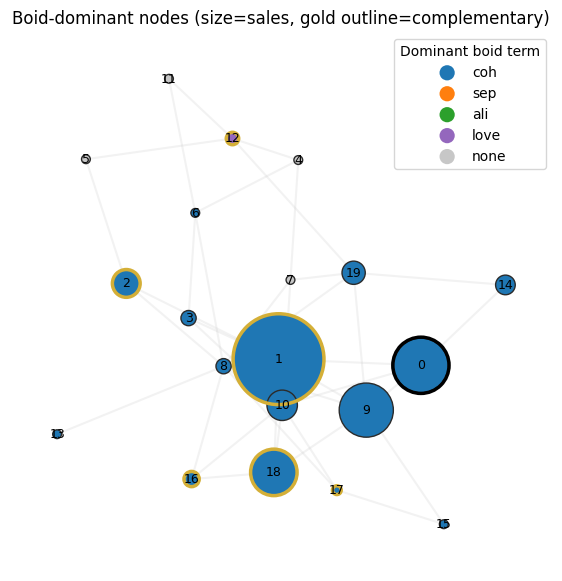

In [3]:
# --- Build layout once (deterministic) ---
G = sim.mall_graph
pos = nx.spring_layout(G, seed=42)

# color map for dominant term
term2color = {"coh":"#1f77b4","sep":"#ff7f0e","ali":"#2ca02c","love":"#9467bd","none":"#c7c7c7"}

# pick dominant term by node (fallback "none")
dom_by_node = {n: max(diag["dominant_term_by_node"].get(n, {"none":0}), key=lambda k: diag["dominant_term_by_node"].get(n, {}).get(k,0))
               for n in G.nodes}

# node sizes by sales
sizes = (df.set_index("node")["sales"] + 1) * 40

# base nodes
node_colors = [term2color.get(dom_by_node[n], "#c7c7c7") for n in G.nodes]

plt.figure(figsize=(7,7))
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1.5, edge_color="#cccccc")
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=sizes, linewidths=1.0, edgecolors="#2b2b2b")

# --- highlight complementary nodes with golden outline ---
comp_nodes = diag["comp_nodes"]
nx.draw_networkx_nodes(G, pos, nodelist=comp_nodes, node_size=sizes[comp_nodes], 
                       node_color="none", edgecolors="#d4af37", linewidths=2.5)

# anchor halo
nx.draw_networkx_nodes(G, pos, nodelist=[A0], node_size=sizes[A0]+80, node_color="none",
                       edgecolors="#000000", linewidths=2.5)

nx.draw_networkx_labels(G, pos, labels={n:str(n) for n in G.nodes}, font_size=9)

# legend dots
for i,(k,c) in enumerate(term2color.items()):
    plt.scatter([],[], s=120, c=c, label=k, edgecolors="none")
plt.legend(title="Dominant boid term", loc="upper right")

plt.title("Boid-dominant nodes (size=sales, gold outline=complementary)")
plt.axis("off")
plt.show()


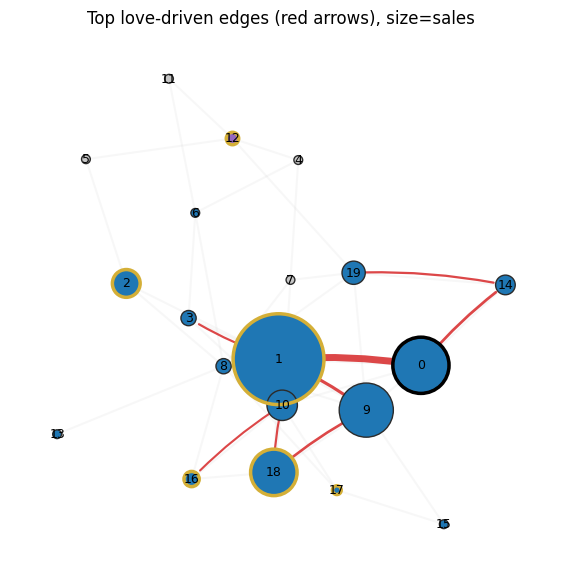

In [4]:
# --- Draw top-K love edges as red arrows (where love actually chose the step) ---
from math import sqrt

love_edges = diag["love_edges"]          # {(u,v): count}
if love_edges:
    K = 8  # show top-K
    top = sorted(love_edges.items(), key=lambda x: x[1], reverse=True)[:K]

    # scale width by count
    counts = np.array([c for _,c in top], dtype=float)
    widths = 1.5 + 3.5 * (counts - counts.min()) / max(1, (counts.max()-counts.min()))

    plt.figure(figsize=(7,7))
    nx.draw_networkx_edges(G, pos, alpha=0.15, width=1.5, edge_color="#cccccc")
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=sizes, linewidths=1.0, edgecolors="#2b2b2b")
    nx.draw_networkx_nodes(G, pos, nodelist=comp_nodes, node_size=sizes[comp_nodes], 
                           node_color="none", edgecolors="#d4af37", linewidths=2.5)
    nx.draw_networkx_nodes(G, pos, nodelist=[A0], node_size=sizes[A0]+80, node_color="none",
                           edgecolors="#000000", linewidths=2.5)
    nx.draw_networkx_labels(G, pos, labels={n:str(n) for n in G.nodes}, font_size=9)

    # red arrows for love-driven steps
    for (idx, ((u,v), cnt)) in enumerate(top):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u,v)],
            width=widths[idx],
            edge_color="#d62728",
            arrows=True,
            arrowsize=18,
            connectionstyle="arc3,rad=0.06",
            alpha=0.85,
        )

    plt.title("Top love-driven edges (red arrows), size=sales")
    plt.axis("off")
    plt.show()
else:
    print("No love-driven edges recorded in this run (try p.w_love ↑ or more steps).")


**Key Observations**

- **Cohesion dominates (blue nodes):**  
  Most high-sales nodes are driven by cohesion—agents cluster around a few dense regions (anchor + neighbors).
- **Complementary stores (gold outlines):**  
  Several complementary nodes near the cluster become secondary hotspots, receiving consistent inflows and sales.
- **Love-driven flows (red arrows):**  
  Directed edges mainly start from the anchor (node 0) and core tenants (nodes 1, 10) and end at complementary nodes (e.g., 16, 18, 2).  
  This visualizes *directed diffusion*—the wallet movement from anchor to complementary areas.
- **Balanced exploration:**  
  Despite strong local cohesion, coverage remains high (≈ 0.75), showing that Boid rules preserve exploration while guiding spending.

---

**Interpretation**

The Boid-enhanced model captures both **collective crowd behavior** and **targeted attraction**:
- *Cohesion + Separation* maintain group integrity and prevent overcrowding.
- *Love* channels part of the traffic toward complementary stores, realizing the “more spending at complementary” hypothesis.
- The result is a self-organizing balance between **anchored concentration** and **outward diffusion**,  
  where anchor quality still defines the core, but collective movement enables realistic spatial spillovers.

---

**Next**

In the next step, we can compare **Model A vs Model B** under Boid dynamics  
to analyze how stronger anchor quality and different love weights alter diffusion and sales concentration.